In [1]:
import sys
import os
import pathlib
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from model import Model
import random
from sklearn import metrics
import seaborn as sns

In [2]:
mode = 'one_letter'
position = ''
class_names = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])
img_size = 28
batch_size = 256
model_dir =  f'model/{mode}' if position == '' else f'model/{mode}/{position}'

AUTOTUNE = tf.data.AUTOTUNE

In [3]:
def get_data():
    if mode == 'one_letter':
        train_dirs = [pathlib.Path('dataset/train/one_letter/normal/prepared'), pathlib.Path('dataset/train/one_letter/medium/prepared'), pathlib.Path('dataset/train/one_letter/bold/prepared')]
        test_dirs = [pathlib.Path('dataset/test/one_letter/normal/prepared'), pathlib.Path('dataset/test/one_letter/medium/prepared'), pathlib.Path('dataset/test/one_letter/bold/prepared')]
    else:
        train_dirs = [pathlib.Path(f'dataset/train/two_letters_combined/{position}')]
        test_dirs = [pathlib.Path(f'dataset/test/two_letters_combined/{position}')]

    train_ds_list = tf.data.Dataset.list_files(str(train_dirs[0]/'*/*'), shuffle=True)
    for train_dir in train_dirs[1:]:
        train_ds_list = train_ds_list.concatenate(tf.data.Dataset.list_files(str(train_dir/'*/*'), shuffle=True))

    train_ds = train_ds_list.take(1000)

    test_ds_list = tf.data.Dataset.list_files(str(test_dirs[0]/'*/*'), shuffle=True)
    for test_dir in test_dirs[1:]:
        test_ds_list = test_ds_list.concatenate(tf.data.Dataset.list_files(str(test_dir/'*/*'), shuffle=True))

    test_ds = test_ds_list.take(1000)

    return train_ds, test_ds

In [4]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    return one_hot


def decode_img(img):
    # convert the compressed string to a 1D uint8 tensor
    img = tf.image.decode_png(img, channels=1)
    img = img / 255
    # resize the image to the desired size - this doesn't work as cv resize!!!
    # return tf.image.resize(img, [img_size, img_size])
    return img


def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [5]:
def analyze_dataset(ds):
    ds_letters = list(ds.map(lambda file_path: tf.strings.split(file_path, os.path.sep)[-2], num_parallel_calls=AUTOTUNE))
    ds_letters_indexes = list(map(lambda x: ord(x.numpy().decode("utf-8")) - 97, ds_letters))
    bincounts = np.bincount(ds_letters_indexes)
    print(bincounts)
    plt.title(f'Velicina skupa: {np.sum(bincounts)}')
    plt.bar(class_names, bincounts)
    plt.show()

In [6]:
train_ds, test_ds = get_data()
print("Test size", tf.data.experimental.cardinality(test_ds).numpy())

Test size 1000


In [7]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = configure_for_performance(train_ds)

256
256
256
232


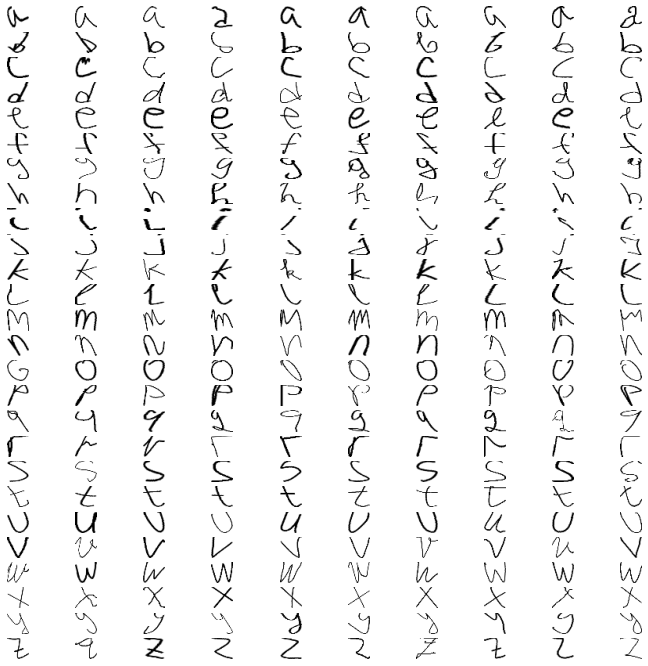

In [8]:
images = [[] for _ in range(26)]
for images_labels in train_ds:
    print(len(images_labels[1]))
    for index in range(len(images_labels[1])):
        label_list = list(map(lambda x: 1 if x else 0, images_labels[1][index].numpy()))
        label = label_list.index(1)
        img = images_labels[0][index].numpy()
        if len(images[label]) < 10:
            images[label].append(img)

fig, axs = plt.subplots(26,10, figsize=(12,12))

for i in range(26):
    for j in range(10):
        axs[i,j].imshow(images[i][j], cmap=plt.cm.gray)
        axs[i,j].set_axis_off()
        #axs[i,j].set_title(f'klasa: {label}')
plt.savefig('report/one_letter/trening_podaci.pdf', format='pdf', bbox_inches='tight')

[46 44 37 42 32 37 30 31 34 33 38 35 42 45 41 29 40 49 52 42 47 37 35 46
 20 36]


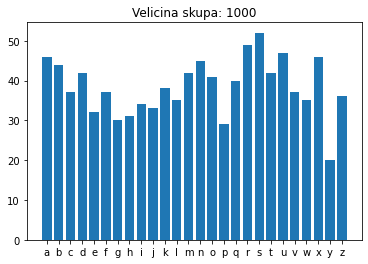

In [9]:
analyze_dataset(test_ds)

In [10]:
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = configure_for_performance(test_ds)

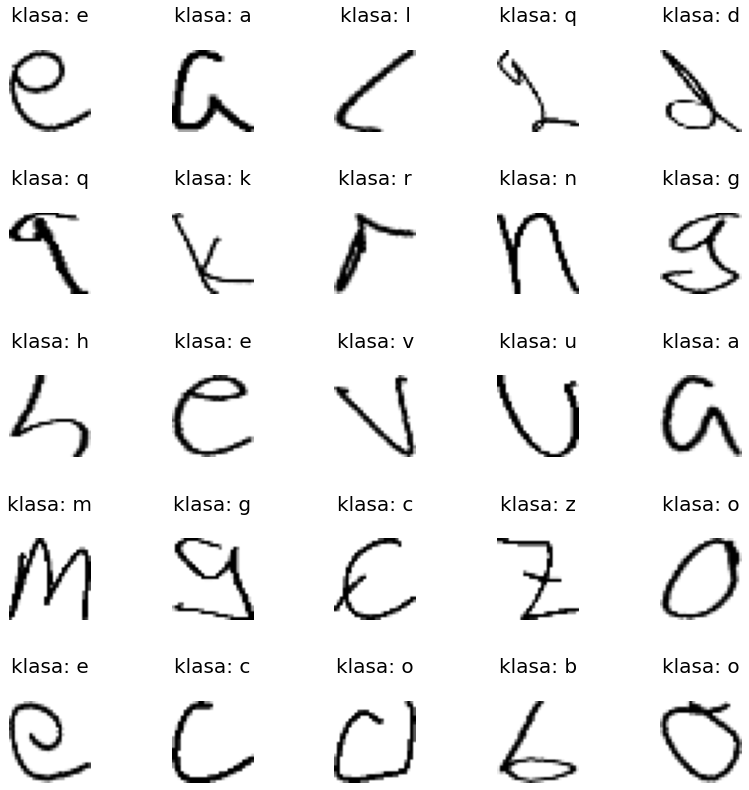

In [11]:
indexes = random.sample(range(batch_size), 25)
fig, axs = plt.subplots(5,5, figsize=(12,12))
fig.tight_layout(pad=5.0)

for images_labels in test_ds.take(1):
    for i in range(5):
        for j in range(5):
            index = indexes[i*5+j]
            label_list = list(map(lambda x: 1 if x else 0, images_labels[1][index].numpy()))
            label = class_names[label_list.index(1)]
            img = images_labels[0][index].numpy()
            axs[i,j].imshow(img, cmap=plt.cm.gray)
            axs[i,j].set_axis_off()
            axs[i,j].set_title(f'klasa: {label}\n', fontsize=20)
plt.savefig('report/one_letter/test_podaci_random_25.pdf', format='pdf', bbox_inches='tight')

In [12]:
model = tf.keras.models.load_model(f'{model_dir}/model.h5')

In [13]:
test_scores = model.evaluate(test_ds)
print("Test accuracy: %s: %.2f%%" % (model.metrics_names[1], test_scores[1]*100))

4/4 [==============================] - 6s 905ms/step - loss: 3.8092 - accuracy: 0.0320
Test accuracy: accuracy: 3.20%


In [14]:
def get_true_predicted_labels(model, ds, class_names):
    true_labels = []
    predicted_labels = []
    for x, y in ds:
        true_labels.extend(class_names[model.predict(x).argmax(axis=1)])
        predicted_labels.extend(class_names[y.numpy().argmax(axis=1)])
    return true_labels, predicted_labels

In [15]:
test_labels, test_predicted = get_true_predicted_labels(model, test_ds, class_names)
metrics.accuracy_score(test_labels, test_predicted)

0.032

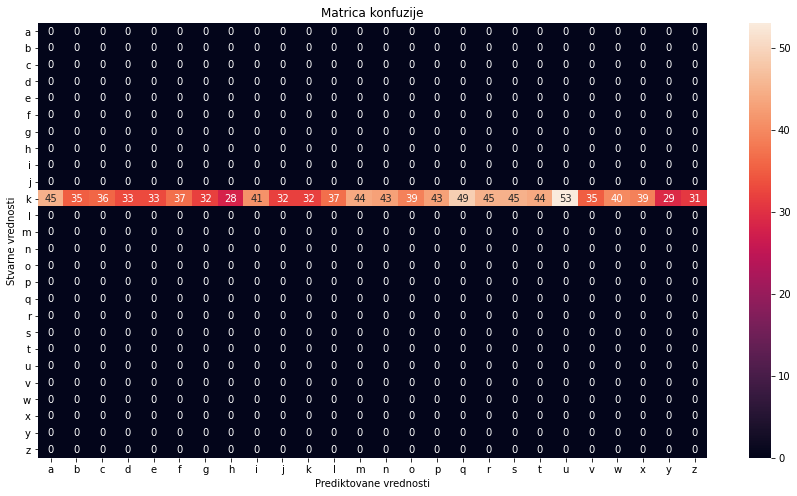

<Figure size 432x288 with 0 Axes>

In [16]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
sns.heatmap(metrics.confusion_matrix(test_labels, test_predicted), annot=True, fmt='g', ax=ax)
ax.set_xlabel('Prediktovane vrednosti')
ax.set_ylabel('Stvarne vrednosti')
ax.set_title('Matrica konfuzije')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names, rotation='horizontal')
plt.show()
plt.clf()

In [17]:
def get_wrong_predictions(model, ds, class_names):
    result_predicted_labels = []
    result_true_labels = []
    result_wrong_images = []
    for images, labels in ds:
        predicted_labels = class_names[model.predict(images).argmax(axis=1)]
        true_labels = class_names[labels.numpy().argmax(axis=1)]
        wrong_indexes = [i for i in range(len(predicted_labels)) if predicted_labels[i] != true_labels[i]]
        result_wrong_images.extend(images.numpy()[wrong_indexes])
        result_true_labels.extend(true_labels[wrong_indexes])
        result_predicted_labels.extend(predicted_labels[wrong_indexes])
    return result_wrong_images, result_true_labels, result_predicted_labels


In [18]:
wrong_images, wrong_true_labels, wrong_predicted_labels = get_wrong_predictions(model, test_ds, class_names)

In [19]:
print(wrong_true_labels)
print(wrong_predicted_labels)

['q', 'b', 'r', 'u', 'f', 'q', 'w', 't', 'f', 'i', 'g', 'f', 'o', 'd', 'p', 'i', 'n', 'a', 'c', 'x', 'w', 'j', 'r', 'v', 'v', 'q', 'q', 'l', 'e', 'n', 'm', 'n', 'i', 'u', 'p', 'z', 'o', 'r', 'g', 'x', 'm', 'r', 'z', 'x', 's', 't', 'b', 'm', 'w', 'v', 'b', 'c', 'a', 't', 'h', 'a', 'n', 'o', 'e', 'a', 'n', 'l', 'd', 't', 'y', 'p', 'w', 'g', 'm', 'f', 'o', 't', 'u', 'o', 'z', 'j', 'q', 'n', 'p', 'm', 'u', 'u', 'u', 'b', 'h', 'd', 'h', 'h', 'u', 'e', 'o', 'l', 'b', 'u', 'a', 'l', 'g', 'r', 'e', 'r', 'a', 'd', 'y', 't', 'q', 'm', 'f', 'o', 'r', 'f', 'e', 'p', 'y', 'o', 'y', 'q', 'c', 'b', 'c', 'a', 'q', 'c', 'r', 'e', 'g', 'w', 'x', 'l', 'f', 'q', 'g', 's', 'l', 'n', 'c', 'w', 'r', 'u', 'z', 'r', 'n', 'l', 'o', 'j', 't', 'f', 'y', 'd', 'x', 'w', 'p', 'v', 'j', 'u', 'j', 't', 'h', 't', 'b', 'r', 'u', 'h', 'b', 'h', 'h', 'l', 'v', 's', 'n', 'u', 'p', 'p', 'n', 'h', 'o', 't', 'u', 'd', 'q', 'h', 'f', 'd', 'u', 'u', 'h', 'g', 's', 'l', 'p', 'n', 'q', 'h', 'e', 'b', 'l', 'b', 'b', 'n', 'u', 'x',

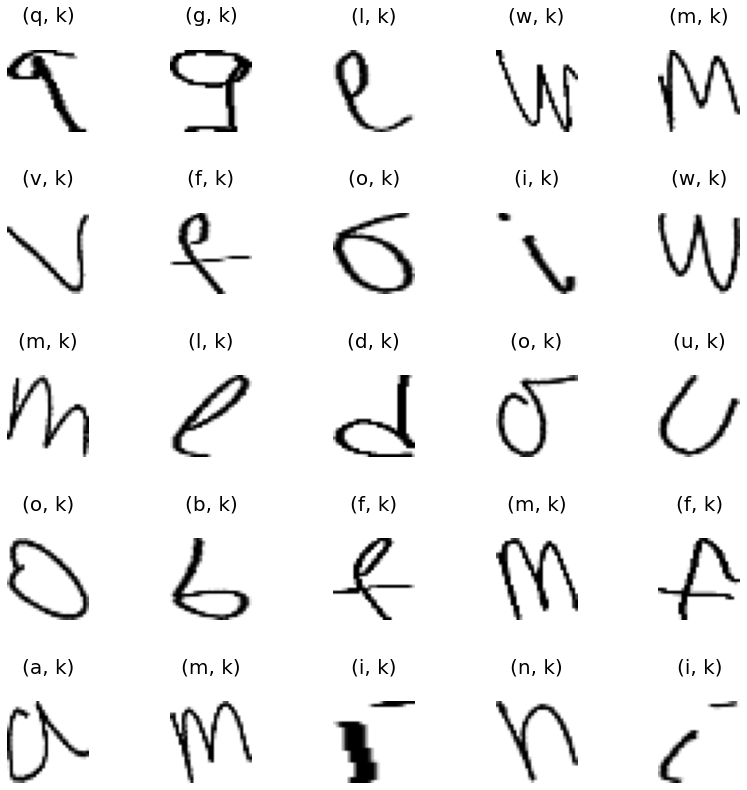

In [25]:
indexes = random.sample(range(len(wrong_images)), min(25, len(wrong_images)))
fig, axs = plt.subplots(5,5, figsize=(12,12))
fig.tight_layout(pad=5.0)

for images_labels in test_ds.take(1):
    for i in range(5):
        for j in range(5):
            if i*5+j >= len(indexes):
                continue
            index = indexes[i*5+j]
            img = wrong_images[index]
            axs[i,j].imshow(img, cmap=plt.cm.gray)
            axs[i,j].set_axis_off()
            axs[i,j].set_title(f'({wrong_true_labels[index]}, {wrong_predicted_labels[index]})\n', fontsize=20)
plt.savefig('report/one_letter/pogresno_prediktovana_slova.pdf', format='pdf', bbox_inches='tight')